In [1]:
import numpy as np
import tensorflow as tf
from DeepAnt import DeepAnt
from WindowGen import WindowGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

UCR_152_PowerDemand1 9000 [18485, 18821]


[]

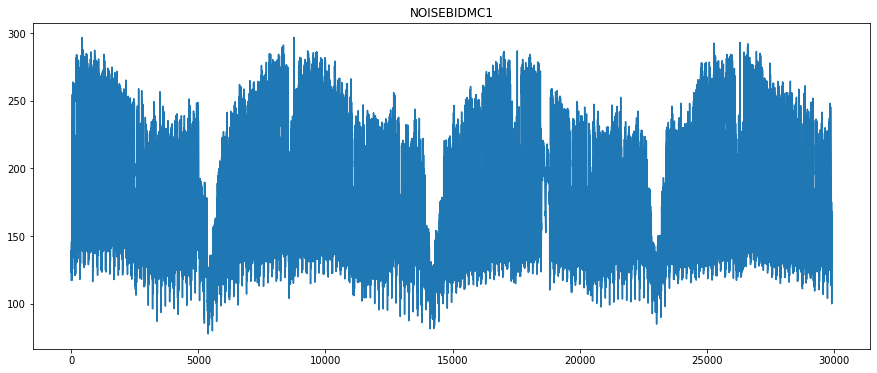

In [2]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
path = '/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/152_UCR_Anomaly_PowerDemand1_9000_18485_18821.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/120_UCR_Anomaly_ECG2_15000_16000_16100.txt'


split_name = str(path).split('/')[-1]
split_name = str(split_name).split('.')[0]
name_aux = str(split_name).split('_')
ds_name = f"{name_aux[1]}_{name_aux[0]}_{name_aux[3]}"
m_v = int(name_aux[4])
an = [int(name_aux[5]), int(name_aux[6])]
print(ds_name, m_v, an)



df_1 = np.genfromtxt(path)
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = 'NOISEBIDMC1', legend = False);
y_ = np.zeros(len(df))
y_[an[0]:an[1]] =1
df['anomaly'] = y_
plt.plot()

In [3]:
from scipy.signal import periodogram
from math import floor
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[24, 12, 168, 9977, 7483, 84, 2993, 28, 34, 21, 8, 12, 1109, 4989, 1761, 29931, 12, 84, 1497, 5986]
[0.04166249039457419, 0.08332498078914838, 0.005947011459690622, 0.00010023053021950487, 0.0001336407069593398, 0.011894022919381244, 0.0003341017673983495, 0.03571547893488356, 0.029768467475192944, 0.04760950185426481, 0.12498747118372255, 0.08322475025892886, 0.0009020747719755437, 0.00020046106043900973, 0.0005679730045771942, 3.341017673983495e-05, 0.08319134008218904, 0.011927433096121078, 0.000668203534796699, 0.00016705088369917476]


In [4]:
w_l = 2*168
p_w = 1

In [5]:
ds = WindowGenerator(input_width= w_l, label_width= p_w, shift = 1, train_df = df['value'].loc[:m_v].to_frame(), test_df = df['value'].to_frame(), val_df = df['value'].to_frame())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


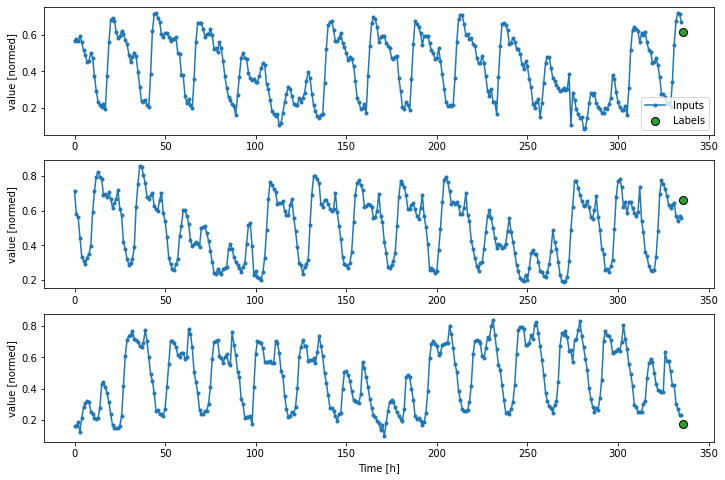

In [6]:
ds.plot(plot_col='value')

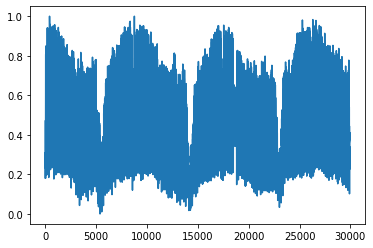

In [7]:
plt.plot(ds.scaler.transform(df['value'].to_frame()))

In [8]:
ds.make_dataset(df['value'].to_frame())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<MapDataset shapes: ((None, 336, 1), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [9]:
DA = DeepAnt(w_l = w_l)

In [10]:
def compile_and_fit(model, window,MAX_EPOCHS = 30, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [ ]:
hist = compile_and_fit(DA, ds, patience =5, MAX_EPOCHS = 30)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
271/271 [==============================] - 6s 19ms/step - loss: 0.0177 - mean_absolute_error: 0.0978 - val_loss: 0.0116 - val_mean_absolute_error: 0.0906
Epoch 2/30
271/271 [==============================] - 5s 20ms/step - loss: 0.0103 - mean_absolute_error: 0.0753 - val_loss: 0.0038 - val_mean_absolute_error: 0.0413
Epoch 3/30
271/271 [==============================] - 6s 21ms/step - loss: 0.0080 - mean_absolute_error: 0.0656 - val_loss: 0.0034 - val_mean_absolute_error: 0.0398
Epoch 4/30
271/271 [==============================] - 7s 26ms/step - loss: 0.0068 - mean_absolute_error: 0.0604 - val_loss: 0.0033 - val_mean_absolute_error: 0.0404
Epoch 5/30
271/271 [==============================] - 7s 27ms/step - loss: 0.0058 - mean_absolute_error: 0.0549 - val_loss: 0.0030 - val_mean_absolute_error: 0.0384
Epoch 6/30
271/271 [==============================] - 7s 25ms/step - loss: 0.0053 - mean_absolute_error: 0.0525 - val_loss: 0.0027 - val_mean_absolute_error: 0.0359
Epoch 7/30

In [ ]:
ds.plot(DA, plot_col='value')

In [ ]:
a =ds.make_ds_pred(data = df['value'].to_frame())

In [ ]:
#loss_ = []
#for X,y in a.as_numpy_iterator(): 
#    loss_.append(np.squeeze(np.abs(y- DA.predict(X))))

In [ ]:
yhat, loss = DA.get_loss(a)

In [ ]:
def plot_predictions(preds, threshold, bins = 80):
    sns.displot(preds, bins = bins, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.title('Loss Distribution')
    plt.legend()

def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Chosen Threshold', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.legend()
    plt.show();

def ts_plot(df, preds, threshold, alg = 'DeepAnT', range = None):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (20,8))
    if range is not None:
        min, max = range
        df = df[min:max]
    plt.plot(df, label = '_nolegend_')
    plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
    plt.title('Detected Anomalies in Time Series')
    plt.legend()
    plt.show();

In [ ]:
l = pd.Series(loss, index = np.arange(w_l,len(df)))

In [ ]:
THRESHOLD = 0.35
plot_predictions(l, THRESHOLD)

In [ ]:
loss_plot(l, 0.4)

In [ ]:
ts_plot(df['value'], l, 0.1)

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(yhat.reshape(-1,1))

In [ ]:
yhat